In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas,numpy,random
import matplotlib.pyplot as plt

In [20]:
class MnistDataset(Dataset):
    def __init__(self,csv_file):
        self.data_df = pandas.read_csv(csv_file,header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros(10)
        target[label] = 1.0

        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        return label,image_values,target

    def plot_image(self,index):
        arr = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr,interpolation='none',cmap='Blues')

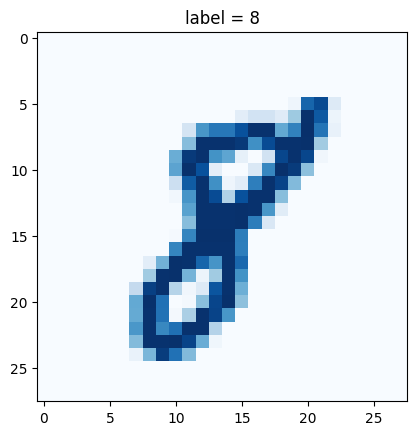

In [21]:
mnist_dataset = MnistDataset('mnist_dataset/mnist_train.csv')
mnist_dataset.plot_image(17)

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 200),
            # nn.Sigmoid(),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),
            
            nn.Linear(200,1),
            nn.Sigmoid()
        )

        # 神经网络执行分类任务时，二元交叉熵更适用。相比于均方误差，它更大程度地奖励正确的分类结果，同时惩罚错误的结果。
        #self.loss_function = nn.MSELoss() # 均方误差
        self.loss_function = nn.BCELoss() # 二元交叉熵
        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []
        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
        pass

In [23]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [24]:
D = Discriminator()
#for label, image_date_tensor, target_tensor in mnist_dataset:
#    D.train(image_date_tensor, torch.FloatTensor([1.0]))
#    D.train(generate_frandom(784), torch.FloatTensor([0.0]))

In [25]:
# D.plot_progress()

In [26]:
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
    print(D.forward(image_data_tensor).item())
for i in range(4):
    print(D.forward(generate_random(784)).item())    

0.2768135070800781
0.2929515838623047
0.4347378611564636
0.17068593204021454
0.26417434215545654
0.31334125995635986
0.4111197888851166
0.3693874776363373


In [27]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 200),
            # nn.Sigmoid(),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            
            nn.Linear(200,784),
            nn.Sigmoid()
        )

        # self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)
        
        self.counter = 0
        self.progress = []
        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
        pass

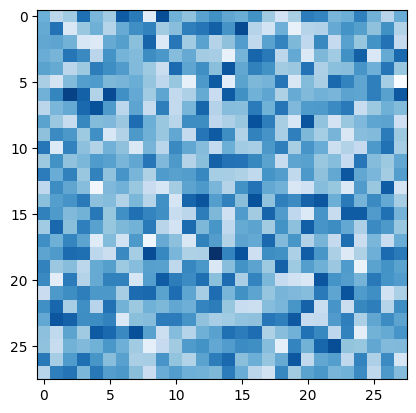

In [28]:
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none',cmap='Blues')

In [29]:
%%time
# 训练鉴别器和生成器
for label, image_data_tensor, target_tensor in mnist_dataset:

    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    # 用生成样本训练鉴别器
    # 使用detach()以避免计算生成器G中的梯度
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 10min 39s, sys: 3min 31s, total: 14min 11s
Wall time: 7min 54s


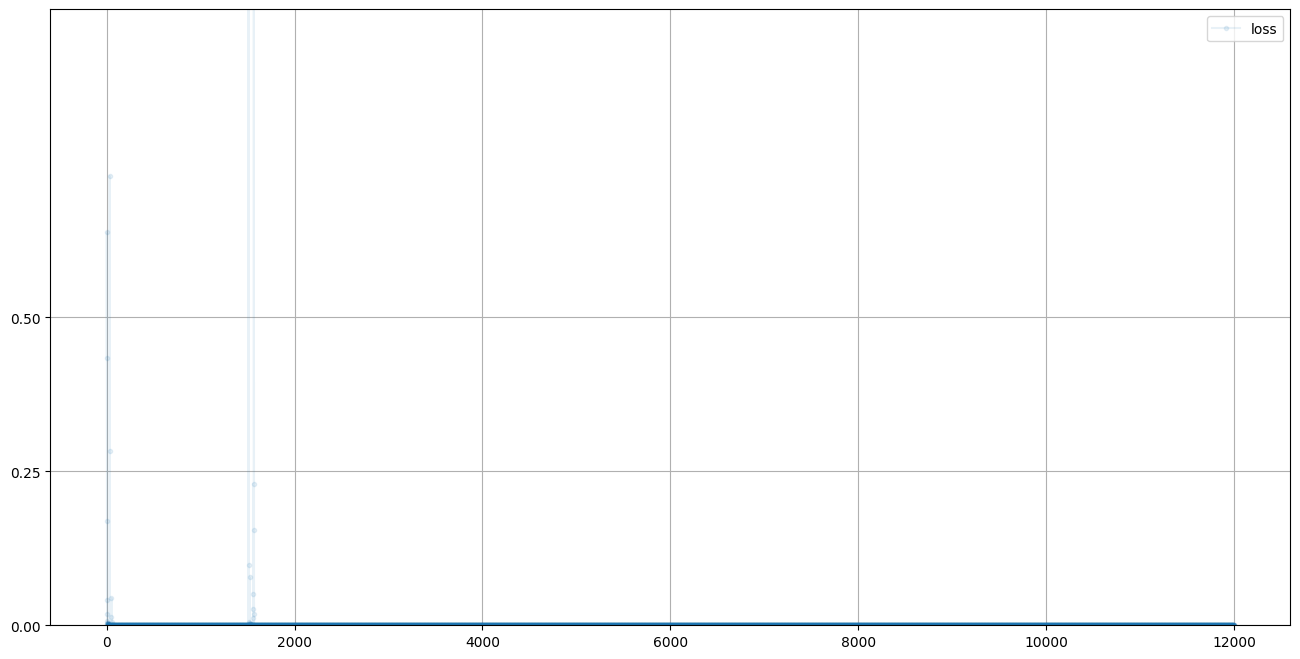

In [30]:
D.plot_progress()

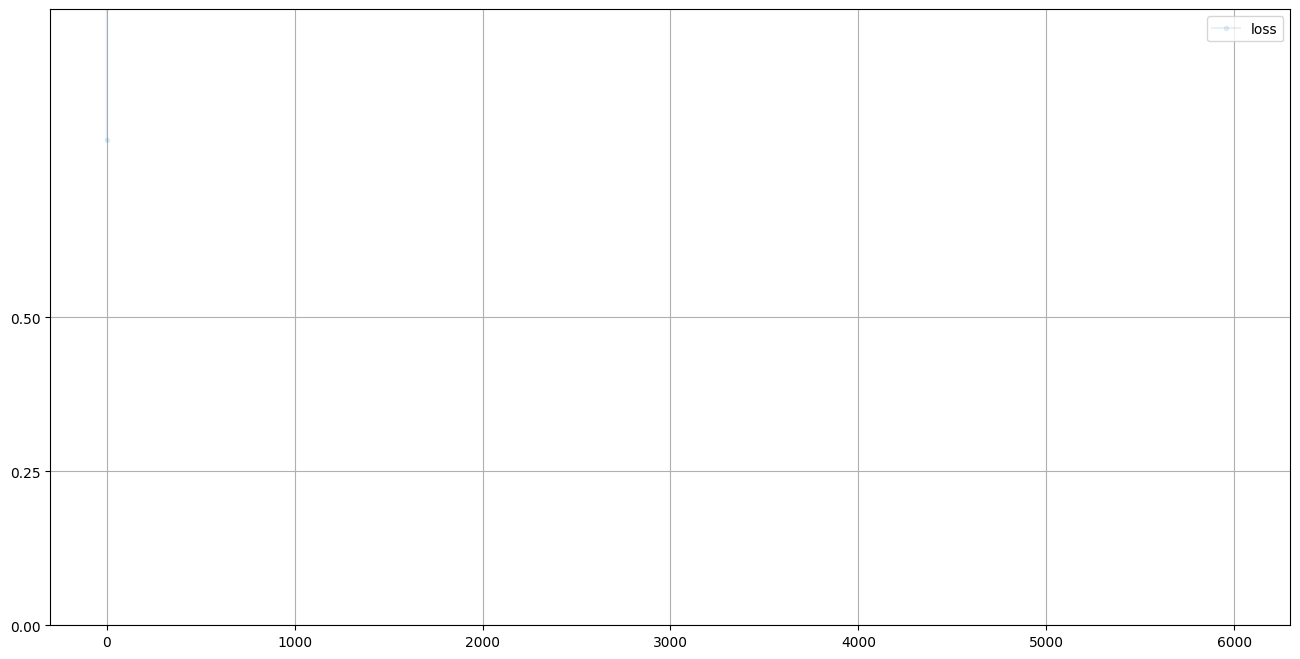

In [31]:
G.plot_progress()

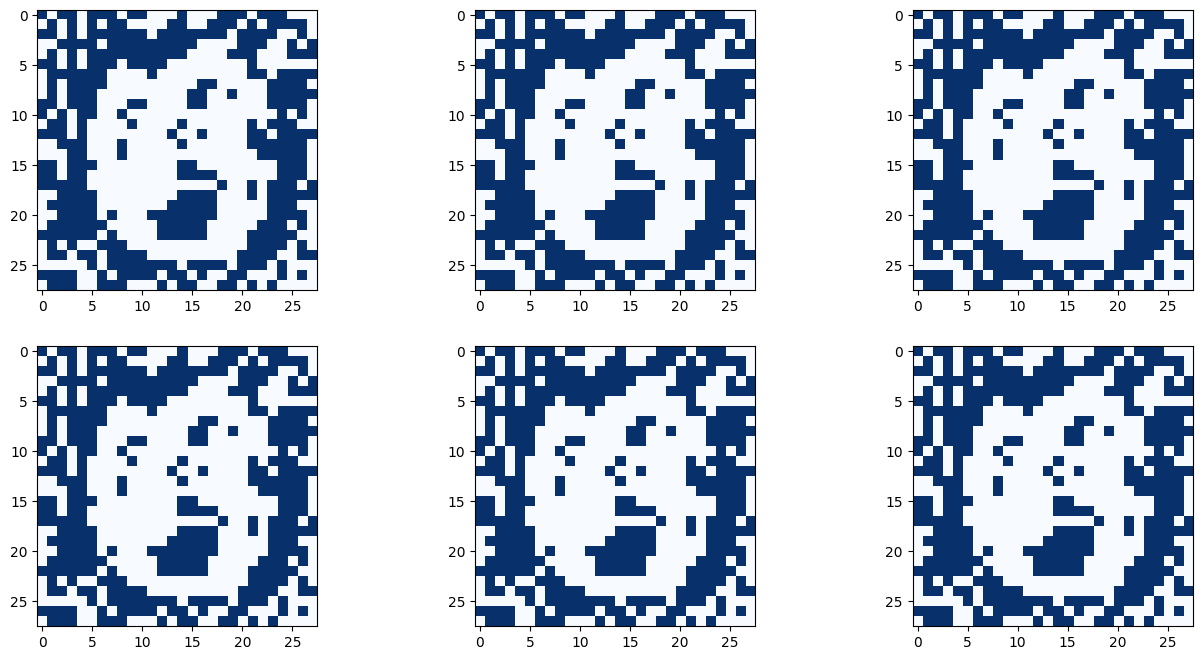

In [32]:
# 在3列2行的网格中生成图像
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass